# 自动报表—盘点
## 01. ERP预分单

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
====================df1数据预览======================
<bound method NDFrame.head of             存货编码  结果      存货名称                规格型号   单位      现存量  库管员  \
0     BF00C50001  相等     铁氧体磁芯           W-W02228A  PCS    20.00  黄明喜   
1     BF26M00050   多     底漆稀释剂                  HK   KG    16.00   蒋鹏   
2     BF26M00051   多      米黄面漆              PC2000   KG    18.00   蒋鹏   
3     BF26M00052   多      灰色底漆        UNIGROUND930   KG   102.00   蒋鹏   
4     BF26M00053   多       固化剂              PC2000   KG     3.60   蒋鹏   
...          ...  ..       ...                 ...  ...      ...  ...   
6948  TT73A20201   少  绝缘垫73...  P15011E06(130A3...  PCS   299.00  齐华香   
6949  TT79A5T006  相等      橡胶衬套            U5972G01  PCS   100.00  谈文丽   
6950  TT79B31028  相等  螺母(TY...            U4167F03  PCS    10.00  谈文丽   
6951  TT79E00805   少       开关盖            U2853C05  PCS 18676.00  谈文丽   
6952  TTY3763C01   多        夹管            Y3

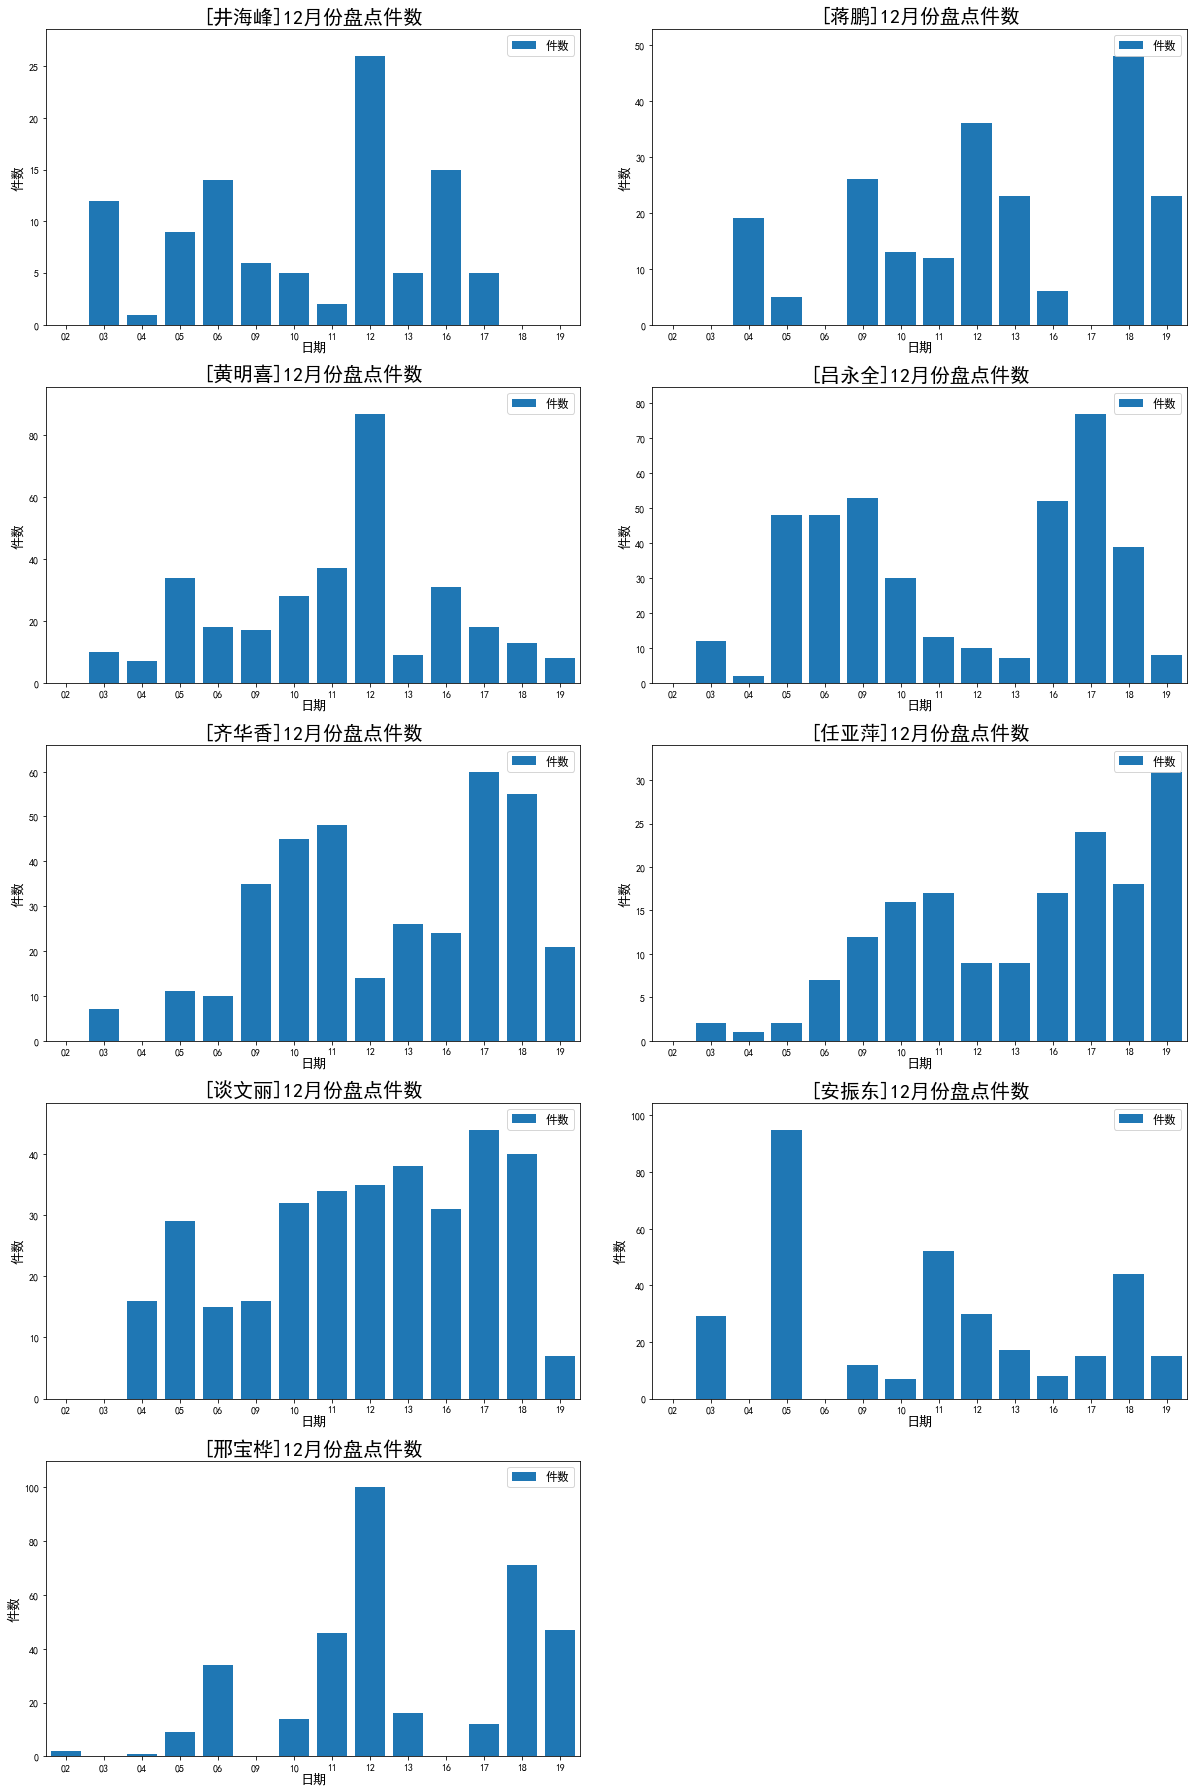

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os

def getDate():
    res = []
    for r in df2['单据日期']:
        res.append(r[8:10])
    return res

def getResult():
    res = []
    for row in df1:
        if(r == 0):
            res.append('相等')
        elif(r > 0):
            res.append('多')
        elif(r < 0):
            res.append('少')
        else:
            res.append(r)
    return res

pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # 禁用科学计数法
#pd.set_option('display.max_rows',None)

#01 打开文件
df_output_stock = pd.read_excel(r'I:\#Data\20191216\限额领料单列表.XLS')
df_erp_stock = pd.read_excel(r'I:\#Data\20191216\库存展望.XLS', logfile=open(os.devnull,'w'))
df_bar_stock = pd.read_excel(r'I:\#Data\20191216\库存汇总表.xlsx',usecols=[0,6])
df_inv_stock = pd.read_excel(r'I:\#Data\20191216\库存盘点单列表.xlsx',usecols=[0,1,2,4,5,6,7,8,9])

#print("出库单=======================")
#print(df_output_stock)
#print("ERP库存=======================")
#print(df_erp_stock)
#print("条码库存=======================")
#print(df_bar_stock)
#print("盘点明细=======================")
#print(df_inv_stock)
#df_inv_stock['盘点日期'] = df_inv_stock.apply(lambda row:str(row[1]))

#02 对限额领料单进行分类汇总，求出出库数量
df_output_stock_sum = df_output_stock.groupby('材料编码').aggregate({'计划出库数量':'sum'}).reset_index()

#03 连接表
df = pd.merge(df_erp_stock,df_output_stock_sum,left_on='存货编码',right_on='材料编码',how='left').fillna(0)[0:-2]

#04 计算列
df['ERP数量'] = df.apply(lambda row: float(row.现存量) - row.计划出库数量, axis=1)
df['存货名称'] = df.apply(lambda row:row[1] if(len(row[1])<=5) else row[1][0:5]+'...',axis=1)
df['规格型号'] = df.apply(lambda row:row[2] if(len(str(row[2]))<=15) else str(row[2])[0:15]+'...',axis=1)
#df_inv_stock['盘点日期'] = df_inv_stock.apply(lambda row:row[1])
#print("ERP库存与出库合计的连接表")
#print(df)

#05 修改列名称
#df.rename(columns={'存货信息存货编码':'存货编码','存货信息存货名称':'存货名称','存货信息规格型号':'规格型号','存货信息主计量单位':'单位','计划出库数量':'出库合计'},inplace=True)


#06 连接ERP库存表与条码库存表
df1 = pd.merge(df,df_bar_stock,left_on='存货编码',right_on='资材编号',how='left').fillna(0)
df1['diff'] = df1.apply(lambda row: row.ERP数量 - row.条码数量, axis=1)
df1.insert(1,'结果',getResult())
#07 显示列信息
#df1 = df1[['存货编码','存货名称','规格型号','单位','库管员','现存量','出库合计','预分单库存','期末数量']]
#df1 = df1[['存货编码','库管员','ERP数量','条码数量']]

print("====================df1数据预览======================")
print(df1.head)







df2 = df_inv_stock[df_inv_stock['单据日期']>'2019/12/01']
df2.insert(2,'日期',getDate())
df4 = pd.pivot_table(
    df2,
    values='单据编号',
    columns='创建人',
    index='日期',
    aggfunc='count',
    fill_value=0,
    #margins=True,
    margins_name='合计')
df3 = df4.reset_index()

plt.figure(figsize=(17,25))
plt.rcParams['font.sans-serif']='SimHei'
person = ['井海峰','蒋鹏','黄明喜','吕永全','齐华香','任亚萍','谈文丽','安振东','邢宝桦']
i=0
for p in person:
    i = i + 1
    plt.subplot(5,2,i,xmargin=0.01,ymargin=0.1)
    x = df3['日期']
    y = df3[p]
    plt.bar(x,y,label="件数")
    plt.legend(fontsize=12)
    plt.xlabel('日期',fontsize=13,labelpad=1)
    plt.ylabel('件数',fontsize=13)
    #plt.xtick(rotation=12)
    plt.title(label='['+p+']12月份盘点件数',fontsize=20)
    
plt.subplots_adjust(left=0,bottom=0,right=1,top=10,wspace=5,hspace=55)
plt.tight_layout()
#plt.savefig('test181518.jpg')


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os

def getDate():
    res = []
    for r in df2['单据日期']:
        res.append(r[8:10])
    return res

def getResult():
    res = []
    for r in df1['diff']:
        res.append(r*10)
    return res

pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # 禁用科学计数法
#pd.set_option('display.max_rows',None)

#01 打开文件
df = pd.read_excel(r'I:\#Data\20191216\sales-funnel.xlsx')
df

,Account,Name,Rep,Manager,Product,Quantity,Price,Status
0,714466,Trantow-Barrows,Craig Booker,Debra Henley,CPU,1,30000,presented
1,714466,Trantow-Barrows,Craig Booker,Debra Henley,Software,1,10000,presented
2,714466,Trantow-Barrows,Craig Booker,Debra Henley,Maintenance,2,5000,pending
3,737550,"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,CPU,1,35000,declined
4,146832,Kiehn-Spinka,Daniel Hilton,Debra Henley,CPU,2,65000,won
5,218895,Kulas Inc,Daniel Hilton,Debra Henley,CPU,2,40000,pending
6,218895,Kulas Inc,Daniel Hilton,Debra Henley,Software,1,10000,presented
7,412290,Jerde-Hilpert,John Smith,Debra Henley,Maintenance,2,5000,pending
8,740150,Barton LLC,John Smith,Debra Henley,CPU,1,35000,declined
9,141962,Herman LLC,Cedric Moss,Fred Anderson,CPU,2,65000,won


In [89]:
df1 = pd.pivot_table(
    df,
    index=['Manager','Status'],
    values=['Price','Quantity'],
    columns=['Product'],
    #margins=True,
    #margins_name='合计',
    aggfunc=np.sum).fillna(0).reset_index()#.set_index('Manager')
df1
df1.to_excel('pivot.xlsx')